In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import logging
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torchvision
import torch.nn as nn
from func.trainer import load_train_objs, prepare_dataloader
from func.nets import simple_net

datadir= Path('/dlab/ldrive/CBT/USLJ-DSDE_DATA-I10008/BenchmarkDatasets/hpa-single-cell-image-classification')
train_dataset_dir = datadir.joinpath('train')
train_csv = datadir.joinpath('train.csv')
test_csv = datadir.joinpath('train_select_1K.csv')
#ckpt_dir = Path('/dlab/ldrive/CBT/USLJ-DSDE_DATA-I10008/shihch3/projects/HPA_single_data/checkpoints/2023_11_30_15_44/best_checkpoint.pth')
ckpt_dir = Path('/dlab/ldrive/CBT/USLJ-DSDE_DATA-I10008/shihch3/projects/HPA_single_data/checkpoints/2023_12_01_13_45/best_checkpoint.pth')
input_ch_ct = 4
batch_size = 32
num_workers = 4
model_input_size = (1024, 1024)
split_ratio = [0.8, 0.1, 0.1]
sample_size = 100
mean = [0.0540, 0.0530, 0.0804, 0.0806]
std = [0.1420, 0.0831, 0.1272, 0.1229]
if isinstance(input_ch_ct, int): 
    mean = mean[:input_ch_ct]
elif isinstance(input_ch_ct, list): 
    std = [std[ch] for ch in input_ch_ct]

_, _, test_ds, _ = load_train_objs(
                            input_ch_ct = input_ch_ct,
                            input_csv = train_csv, 
                            data_root = train_dataset_dir,
                            split_ratio = split_ratio,
                            sample_size = sample_size, 
                            deterministic = True, 
                            mean = mean, std = std)

test_loader = prepare_dataloader(test_ds, batch_size, num_workers, sampler = None)
model = simple_net(input_ch_ct, model_input_size)
model.load_state_dict(torch.load(ckpt_dir))
model.eval()

train_ds size: 80
val_ds size: 10
val_ds size: 10


simple_net(
  (conv1): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=19, bias=True)
)

In [15]:
def show_transformed_images(dataloader, post_transform = None): 
    batch = next(iter(dataloader))
    images = batch['image']
    labels = batch['label']

    if not post_transform is None:
        images = post_transform(images)
    
    labels_anno = []
    for label in labels: 
        labels_anno.append((label==1).nonzero().flatten().tolist())

    m = nn.Sigmoid()
    outputs = model(images)
    outputs = m(outputs)

    output_anno = []
    for output in outputs: 
        output_anno.append((output>=0.5).nonzero().flatten().tolist())

    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, scale_each=True)
    plt.figure(figsize = (11, 11))
    img_tmp = np.transpose(grid, (1, 2, 0))
    plt.imshow(img_tmp)
    print('labels', labels_anno)
    print('outputs', output_anno)

    

labels [[16], [0, 12], [0], [0], [0, 16], [6, 16], [13], [14], [4, 16], [3]]
outputs [[13, 16], [0], [0], [0], [0], [0], [0], [], [0], []]


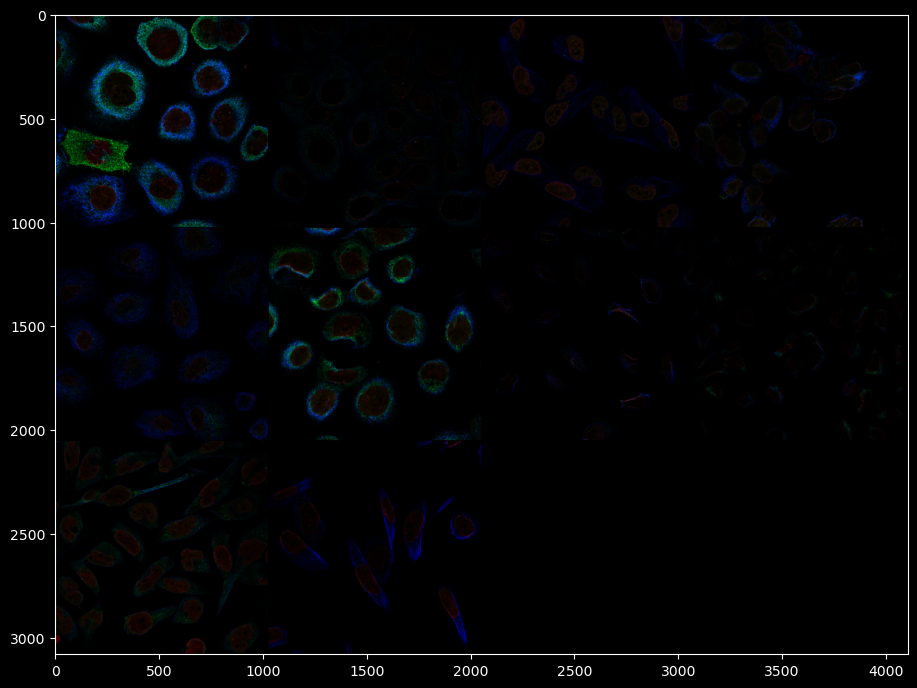

In [16]:
show_transformed_images(test_loader)